In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
import json
import os

from results_config import *

In [3]:
import sys
sys.path.append("scripts/")
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import full_preproc, clean


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
s = load_sara()
processed_emails = [clean(a) for a in s.text]
ids = s.doc_id.tolist()
sens = s.sensitivity.tolist()
texts = [' '.join(processed_emails[i]) for i, text in enumerate(s.text)]
new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
s = pd.DataFrame.from_dict(new_dict)

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", use_fast=True)


#### Reading results

In [6]:
def get_join(doc_ids, preds, gts):
    clean_doc_ids = {}
    for i, idd in enumerate(doc_ids):
        if '_' in idd:
            idd = idd[:idd.find('_')]

        p = preds[i]
        gt = gts[i]
        if p is None:
            p = 1.0
        new_pred = {
            'doc_id': idd,
            'prediction': p,
            'ground_truth': gt,
        }
        if idd not in clean_doc_ids.keys():
            clean_doc_ids[idd] = new_pred
            continue
        if p == 0:
            continue
        clean_doc_ids[idd] = new_pred
    return clean_doc_ids

In [7]:
import numpy as np
import pandas as pd
import re
import email
import gensim

def no_reply_proc(s, tokenizer, c_size=2048):

    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df

    return main(s)

clean_unique_docs = no_reply_proc(load_sara(), '')

In [8]:
def new_get_join(data):
    collected_truths = []
    collected_docids = []
    mapp = {}
    for item in data:
        doc_id = item.get('doc_id')
        if '_' in doc_id:
            doc_id = doc_id[:doc_id.find('_')]
        truth = clean_unique_docs[clean_unique_docs.doc_id == doc_id].iloc[0].sensitivity
        pred = item.get('prediction')

        if doc_id not in collected_docids:
            if pred is None:
                pred = 1
            collected_docids.append(doc_id)
            collected_truths.append(truth)
            new_pred = {
                'doc_id': doc_id,
                'prediction': pred,
                'ground_truth': truth,
            }
            mapp[doc_id] = new_pred

        if pred == 1:
            new_pred = {
                'doc_id': doc_id,
                'prediction': int(pred),
                'ground_truth': int(truth),
            }
            mapp[doc_id] = new_pred

    mapp = list(mapp.values())
    return pd.DataFrame(mapp)

In [9]:
def get_results_json(mname, clean=True):
    current_directory = os.getcwd()
    #parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(current_directory, f'scripts/results/model_results/{mname}/')
    #print("Path to results", target_directory)
    prompt_results = os.listdir(target_directory)
    main_results = []
    prompts_and_answers = {
        'multi_category': 'does not', 
        'pers_multi': 'non-personal', 
        'barlit':'non-sensitive',
        'text': 'non-sensitive',
        'pdc': 'non-personal',
        'cg': 'non-personal',
        'textfew': 'non-sensitive',
        'pdcfew': 'non-personal',
        'cgfew': 'non-personal',
        'base_personal': 'does not'
    }
    prompts = list(prompts_and_answers.keys())
    for prompt in prompt_results:
        if prompt not in prompts:
            continue
        #prompt = 'base_personal'
        prompt_path = os.path.join(target_directory, prompt)
        file_path = os.path.join(prompt_path, 'all_responses.json')
        #print(file_path)
        with open(file_path) as json_file:
            data = json.load(json_file)

        new_data = [] #{doc_id, prediction, ground_truth}
        for i, v in enumerate(data):
            idd = v.get('doc_id')
            gt = v.get('ground_truth')
            ans = v.get('generated_response')
            #ans = 'The text does contain sensitive'
            class_seg = ans[:25]
            negative = prompts_and_answers.get(prompt)
            if negative in ans:
                pred = 0
            else:
                pred = 1

            new_data.append({'doc_id': idd, 'prediction': pred, 'ground_truth': gt, 'model':mname, 'prompt': prompt, 'generated_response':ans})
        data = new_data

        if not clean:
            main_results += data
            continue

        data_df = new_get_join(data)
        clean_json = []
        for i, v in data_df.iterrows():
            clean = {
                'doc_id': v.doc_id,
                'prediction': v.prediction,
                'ground_truth': v.ground_truth,
                'model': mname,
                'prompt': prompt
            }
            clean_json.append(clean)

        main_results += clean_json
    df = pd.DataFrame(main_results)
    return df

In [10]:
all_results_df = get_results_json('mist-noreply')
gen_results_df = get_results_json('mist7b-mist', clean=False)

In [11]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
12587,125762,1,0,mist-noreply,multi_category
12588,234238,0,0,mist-noreply,multi_category
12589,174214,0,0,mist-noreply,multi_category
12590,175841,1,0,mist-noreply,multi_category


In [12]:
#all_results_df[(all_results_df.prediction!=0) & (all_results_df.prediction!=1)]


In [13]:
prompt = 'base_personal'
inter = all_results_df[all_results_df.prompt == prompt]
y1 = inter['prediction'].values
y2 = inter['ground_truth'].values
balanced_accuracy_score(y2, y1)

0.5824027724297266

In [14]:
#s = full_preproc(load_sara(), tokenizer)

#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [15]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group):
    return f1_score(group['ground_truth'], group['prediction'], average='weighted')

def calc_prec(group):
    return precision_score(group['ground_truth'], group['prediction'])

def calc_rec(group):
    return recall_score(group['ground_truth'], group['prediction'])

def tpr(group):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tpr = tp / (tp+fn)
    return tpr

def tnr(group):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tnr = tn / (tn+fp)
    return tnr

def calculate_f2(group):
    return fbeta_score(group['ground_truth'], group['prediction'], average='weighted', beta=2)

def auroc(group):
    return roc_auc_score(group['ground_truth'], group['prediction'])

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='balanced_accuracy')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='f1_score')
    prec_df = grouped.apply(calc_prec).reset_index(name='prec')
    rec_df = grouped.apply(calc_rec).reset_index(name='recall')
    tpr_df = grouped.apply(tpr).reset_index(name='tpr')
    tnr_df = grouped.apply(tnr).reset_index(name='tnr')
    f2_score_df = grouped.apply(calculate_f2).reset_index(name='f2_score')
    auroc_df = grouped.apply(auroc).reset_index(name='auroc')


    # Merge results into a single DataFrame - easy comparison
    performance_df = accuracy_df
    performance_df = pd.merge(performance_df, prec_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tpr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tnr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f2_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, balanced_accuracy_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, auroc_df, on=['model', 'prompt'])

    #performance_df = pd.merge(performance_df, rec_df, on=['model', 'prompt'])


    #print(performance_df)
    return performance_df

prompt_performance_df = prompt_performance(all_results_df)

In [16]:
prompt_performance_df

,model,prompt,accuracy,prec,tpr,tnr,f1_score,f2_score,balanced_accuracy,auroc
0,mist-noreply,base_personal,0.506353,0.157833,0.683673,0.481132,0.583947,0.516411,0.582403,0.582403
1,mist-noreply,cg,0.644854,0.219474,0.724490,0.633527,0.705110,0.655269,0.679008,0.679008
2,mist-noreply,cgfew,0.618170,0.206946,0.729592,0.602322,0.682915,0.628498,0.665957,0.665957
3,mist-noreply,multi_category,0.649936,0.199662,0.602041,0.656749,0.708503,0.663367,0.629395,0.629395
4,mist-noreply,pdc,0.476493,0.158696,0.744898,0.438316,0.553042,0.482140,0.591607,0.591607
5,mist-noreply,pdcfew,0.553367,0.180328,0.729592,0.528302,0.626419,0.562852,0.628947,0.628947
6,mist-noreply,text,0.604193,0.080550,0.209184,0.660377,0.666701,0.625402,0.434781,0.434781
7,mist-noreply,textfew,0.596569,0.108734,0.311224,0.637155,0.663037,0.617256,0.474190,0.474190


In [17]:
prompt_performance_df = prompt_performance_df

prompt_order = ['base_sens', 'base2_sens', 'context_b1_sens', 'context_b2_sens', 'base_personal', 'context_b1_personal', 'fixed_fewshot_personal', 'base_personal_explanation', 'purely_personal', 'itspersonalgenres', 'multi_category_noanseng', 'multi_category', 'base_classify', 'barlit', 'barlit2']
prompt_order = ['base_personal', 'multi_category', 'text', 'pdc', 'cg', 'textfew', 'pdcfew', 'cgfew']
prompt_performance_df['prompt'] = pd.Categorical(prompt_performance_df['prompt'], categories=prompt_order, ordered=True)
prompt_performance_df = prompt_performance_df.sort_values('prompt')

#print(prompt_performance_df)
prompt_performance_df


,model,prompt,accuracy,prec,tpr,tnr,f1_score,f2_score,balanced_accuracy,auroc
0,mist-noreply,base_personal,0.506353,0.157833,0.683673,0.481132,0.583947,0.516411,0.582403,0.582403
3,mist-noreply,multi_category,0.649936,0.199662,0.602041,0.656749,0.708503,0.663367,0.629395,0.629395
6,mist-noreply,text,0.604193,0.080550,0.209184,0.660377,0.666701,0.625402,0.434781,0.434781
4,mist-noreply,pdc,0.476493,0.158696,0.744898,0.438316,0.553042,0.482140,0.591607,0.591607
1,mist-noreply,cg,0.644854,0.219474,0.724490,0.633527,0.705110,0.655269,0.679008,0.679008
7,mist-noreply,textfew,0.596569,0.108734,0.311224,0.637155,0.663037,0.617256,0.474190,0.474190
5,mist-noreply,pdcfew,0.553367,0.180328,0.729592,0.528302,0.626419,0.562852,0.628947,0.628947
2,mist-noreply,cgfew,0.618170,0.206946,0.729592,0.602322,0.682915,0.628498,0.665957,0.665957


In [18]:
all_results_df = get_results_json('mist-noreply')
prompt_performance_df = prompt_performance(all_results_df)


### Document Difficultly

In [19]:
prompts = ['text', 'pdc', 'cg', 'pdc2', 'textfew', 'pdcfew', 'cgfew']

In [20]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

slim = ['base_personal', 'fixed_fewshot_personal', 'purely_personal', 'itspersonalgenres', 'multi_category']
slim = prompts
focused_df = all_results_df[all_results_df['prompt'].isin(slim)]
most_difficult_docs = get_most_difficult_docs(focused_df)
all_wrong = get_all_wrong()
#all_wrong = most_difficult_docs[:100]
all_wrong

,doc_id,misclassification_rate
1497,54668,1.0
1177,191480,1.0
1230,220532,1.0
462,173846,1.0
1492,54663,1.0
...,...,...
20,115333,1.0
1555,82354,1.0
1022,175968,1.0
610,174259,1.0


In [21]:
doc_ids = all_wrong.doc_id.to_list()
filtered_df = s[s['doc_id'].isin(doc_ids)]
print(filtered_df)

'''
for i, row in filtered_df.iterrows():
    print(row.doc_id)
    print(row.text)
    print()
'''

      doc_id                                               text  sensitivity
3      62815  louise lisa yoho suggested i forward the attac...            0
24    139495  i agree with morris little value to the pipes ...            0
26    139507  i have forwarded to stan and agree with your p...            0
52     82352  ill get back with you on this within a couple ...            0
54     82354  nepool info from giffels kevin presto ubs warb...            0
...      ...                                                ...          ...
1510  175721  your assessment makes perfect sense to me what...            0
1527   54676  original message from huang alex sent tuesday ...            1
1563   54625  original message from gibner stinson sent wedn...            1
1568   54663  thanks vince original message from j d duffie ...            0
1648  192024  steve i only have the following suggestion for...            0

[63 rows x 3 columns]


'\nfor i, row in filtered_df.iterrows():\n    print(row.doc_id)\n    print(row.text)\n    print()\n'

In [22]:
sum(filtered_df.sensitivity.to_list())

16

In [23]:
print(len(filtered_df))
proc_filtered_df = full_preproc(filtered_df, tokenizer)
print(len(proc_filtered_df))

63
72


In [24]:
doc_lengths = s.text.str.len()
print(sorted(doc_lengths.values, reverse=True))

[207061, 190116, 190116, 171851, 171851, 169371, 169371, 151783, 151783, 151783, 131958, 131958, 127632, 127632, 127632, 127632, 127632, 127632, 113765, 113765, 112401, 112401, 110186, 110186, 110186, 110186, 110186, 110186, 110186, 104395, 104395, 104395, 104395, 104395, 100077, 100077, 100077, 90210, 90210, 90210, 85611, 85611, 81297, 78496, 78496, 78496, 78496, 78496, 67419, 67419, 67419, 67419, 67419, 62917, 62917, 62541, 61299, 61299, 59862, 59862, 59862, 59862, 59862, 56536, 51431, 45835, 43595, 39742, 31633, 31441, 30067, 30059, 29885, 28093, 27194, 23322, 21475, 21318, 21194, 20554, 20532, 20478, 20372, 20290, 20240, 20195, 15262, 14253, 14130, 13424, 13293, 13293, 13049, 12552, 12377, 12321, 12305, 11384, 11113, 11111, 10952, 10761, 10563, 10351, 10327, 10266, 10074, 9860, 9205, 9205, 8986, 8639, 8393, 8350, 8249, 8090, 8070, 8045, 7952, 7801, 7787, 7766, 7568, 7499, 7305, 7300, 7244, 7164, 7155, 7154, 7119, 7118, 7097, 7056, 6985, 6937, 6585, 6574, 6435, 6384, 6347, 6346, 628

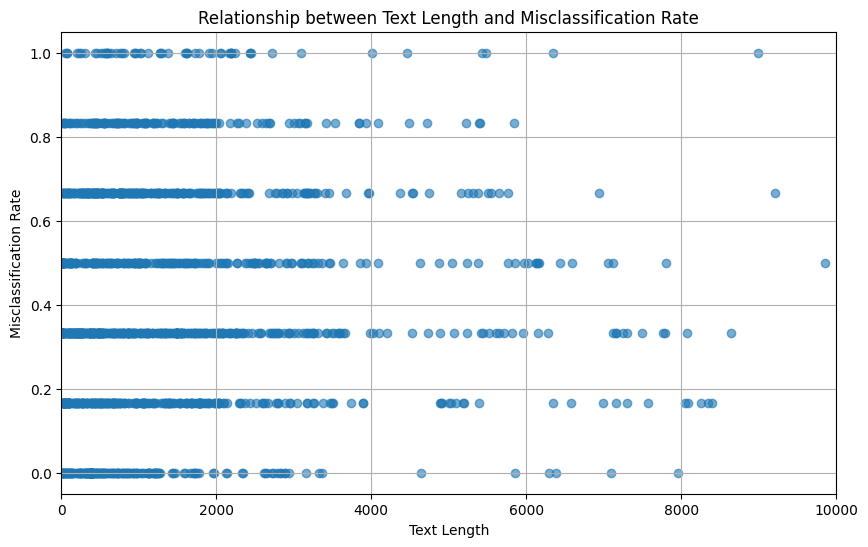

In [25]:
pdf = pd.merge(s, most_difficult_docs, on=['doc_id'])
pdf
df = pdf
df['text_length'] = df['text'].apply(len)

# Plotting the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['misclassification_rate'], alpha=0.6)
plt.title('Relationship between Text Length and Misclassification Rate')
plt.xlabel('Text Length')
plt.ylabel('Misclassification Rate')
plt.grid(True)
plt.xlim(0, 10000)
plt.show()

In [26]:
all_wrong_df = filtered_df
for i, v in all_wrong_df.iterrows():
    print('Document', v.doc_id, 'Class', v.sensitivity, 'Cat', hearst_genres.get(mapp.get(v.doc_id)))
    print(v.text)
    print()

NameError: name 'hearst_genres' is not defined

### Statistical Testing - McNemar

<Figure size 500x500 with 0 Axes>

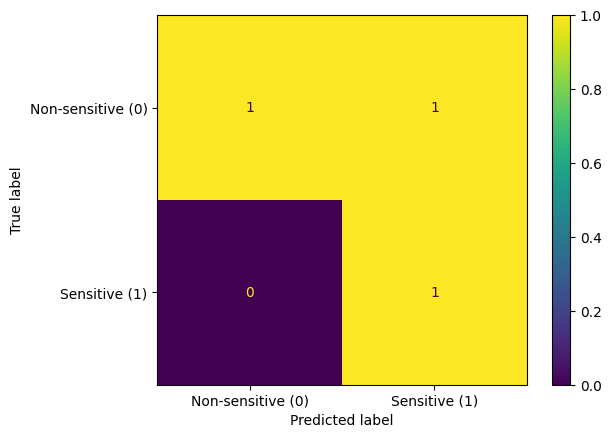

In [27]:
def evaluation_summary(true_labels, predictions):
    target_labels = [0, 1]
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    report = classification_report(true_labels, predictions, labels=target_labels, target_names=target_classes, digits=3, zero_division=0)
    #print(report)
    confusionMatrix = confusion_matrix(true_labels, predictions, labels=target_labels)
    fig = plt.figure(1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes)
    disp.plot()
    #disp.figure_.savefig(description+"confusion_matrix.pdf")
    plt.show()
    return disp

evaluation_summary([1,0,0], [1,0,1])

<Figure size 500x500 with 0 Axes>

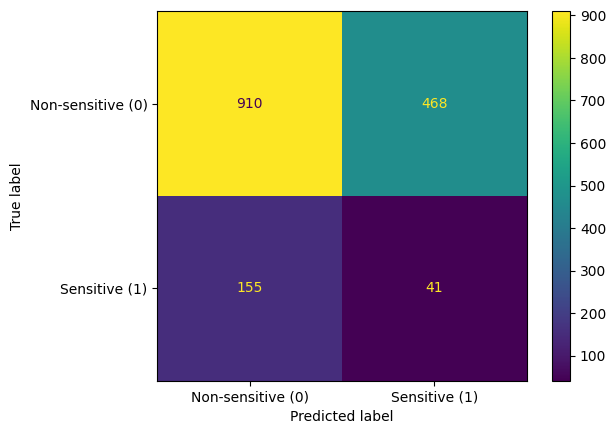

<Figure size 500x500 with 0 Axes>

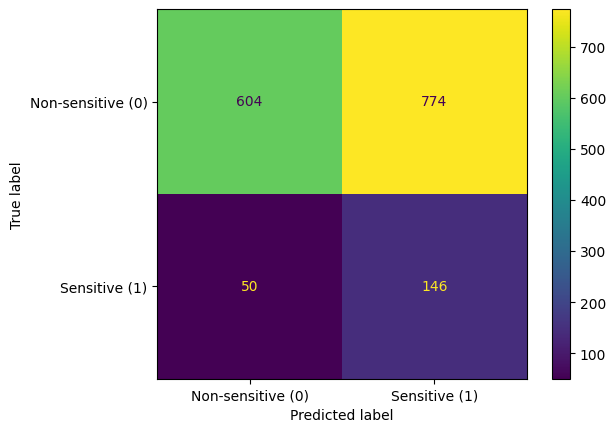

<Figure size 500x500 with 0 Axes>

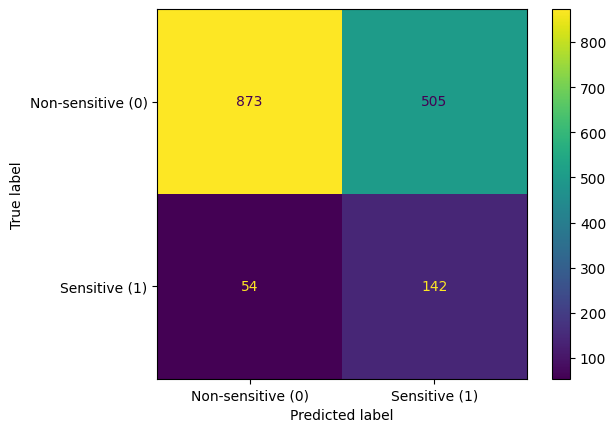

In [28]:
p = all_results_df[all_results_df.prompt == 'text'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'text'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'pdc'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'pdc'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'cg'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'cg'].ground_truth.to_list()

evaluation_summary(t, p)

#p = all_results_df[all_results_df.prompt == 'itspersonalgenres'].prediction.to_list()
#t = all_results_df[all_results_df.prompt == 'itspersonalgenres'].ground_truth.to_list()
#evaluation_summary(t, p)


In [29]:
focused_df.prompt.unique()

array(['cgfew', 'textfew', 'pdc', 'text', 'cg', 'pdcfew'], dtype=object)

In [30]:
from statsmodels.stats.contingency_tables import mcnemar

# Example predictions
# Let's assume 0 for incorrect predictions and 1 for correct predictions
model1_predictions = [1, 0, 1, 1, 0, 1, 0, 1]
model2_predictions = [1, 1, 1, 0, 0, 0, 1, 0]

# Building the contingency table
contingency_table = [[0, 0], [0, 0]]

for pred1, pred2 in zip(model1_predictions, model2_predictions):
    contingency_table[pred1][pred2] += 1

contingency_table

[[1, 2], [3, 2]]

In [31]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if (model_name != model_name2) and (prompt_name != prompt_name2):
        print('Multiple difference')
        return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_prompt(non_results_df, prompt_name, prompt_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_prompt(sen_results_df, prompt_name, prompt_name2)
    else:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_model(non_results_df, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_model(sen_results_df, model_name, model_name2)

    print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table), end='')
    #print(np.matrix(non_table), end='')

    print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))
    return overall_table

'''
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('multi_category','cg'), ('base_personal', 'pdc')]
#compare = [('cg', 'cgfew')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
    run_mcnemar(overall)
'''

'\nmodel_name = \'mist-noreply\'\nmodel_name2 = \'mist-noreply\'\n\ncompare = [(\'multi_category\',\'cg\'), (\'base_personal\', \'pdc\')]\n#compare = [(\'cg\', \'cgfew\')]\n\nfor v in compare:\n    print("""Mcnemar\'s where,\n                        Condition 2 Positive\t    Condition 2 Negative\nCondition 1 Positive\tA (Positive at both times)\tB (Positive then Negative)\nCondition 1 Negative\tC (Negative then Positive)\tD (Negative at both times)\n    """)\n    print(\'Control:\', v[0], \'\tChange:\', v[1])\n    prompt_name = v[0]\n    prompt_name2 = v[1]\n    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)\n    run_mcnemar(overall)\n'

In [32]:
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), 
           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]
#compare = [('cg', 'cgfew')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    run_mcnemar(overall)

Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: text 	Change: pdc
Overall		 Non-sensitive only	 Sensitive only
[[483 468]] 	 [[451 459]] 		 [[32  9]]
[[267 356]] 	 [[153 315]] 		 [[114  41]]
statistic=267.000, p-value=1.1447E-13
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: text 	Change: cg
Overall		 Non-sensitive only	 Sensitive only
[[595 356]] 	 [[568 342]] 		 [[27 14]]
[[420 203]] 	 [[305 163]] 		 [[115  40]]
statistic=356.000, p-value=2.3662E-02
Different proportions of errors (reject H0)
Mcnemar's where,
                        Conditio

In [33]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    return result.statistic, result.pvalue
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if (model_name != model_name2) and (prompt_name != prompt_name2):
        print('Multiple difference')
        return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_prompt(non_results_df, prompt_name, prompt_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_prompt(sen_results_df, prompt_name, prompt_name2)
    else:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_model(non_results_df, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_model(sen_results_df, model_name, model_name2)

    return overall_table

model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), 
           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]
#compare = [('cg', 'cgfew')]

stat_tests = []
for v in compare:
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    stat, p = run_mcnemar(overall)
    stat_tests.append({'model':model_name, 'original': v[0], 'change': v[1], 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.05)})
stat_tests = pd.DataFrame.from_dict(stat_tests)
print(stat_tests)


Control: text 	Change: pdc
Control: text 	Change: cg
Control: pdc 	Change: cg
Control: text 	Change: textfew
Control: pdc 	Change: pdcfew
Control: cg 	Change: cgfew
          model original   change  statistic   p-value  significant
0  mist-noreply     text      pdc      267.0  1.14E-13         True
1  mist-noreply     text       cg      356.0  2.37E-02         True
2  mist-noreply      pdc       cg       92.0  6.65E-38         True
3  mist-noreply     text  textfew      242.0  6.21E-01        False
4  mist-noreply      pdc   pdcfew      134.0  8.63E-10         True
5  mist-noreply       cg    cgfew      130.0  1.82E-02         True


In [34]:
focused_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
9439,125762,0,0,mist-noreply,pdcfew
9440,234238,0,0,mist-noreply,pdcfew
9441,174214,0,0,mist-noreply,pdcfew
9442,175841,1,0,mist-noreply,pdcfew


In [40]:
mistall_results_df = get_results_json('mist-noreply')
l2all_results_df = get_results_json('l27b-noreply')

df = pd.concat([mistall_results_df, l2all_results_df])


In [47]:
mixtall_results_df = get_results_json('mixt-noreply')
flanall_results_df = get_results_json('flanxl-noreply')

df = pd.concat([df, mixtall_results_df])
df = pd.concat([df, flanall_results_df])

In [50]:
model_name = 'mist-noreply'
model_name2 = 'flanxl-noreply'

compare = [('text','text'), ('pdc', 'pdc'), ('cg', 'cg'), 
           ('cgfew', 'cgfew')]
#compare = [('cg', 'cgfew')]

stat_tests = []
for v in compare:
    print('Control:', model_name, '\tChange:', model_name2)
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df)
    print(overall)
    stat, p = run_mcnemar(overall)
    stat_tests.append({'prompt':v[0], 'original': model_name, 'change': model_name2, 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.05)})
stat_tests = pd.DataFrame.from_dict(stat_tests)
print(stat_tests)

Control: mist-noreply 	Change: flanxl-noreply
[[903, 48], [448, 175]]
Control: mist-noreply 	Change: flanxl-noreply
[[632, 118], [720, 104]]
Control: mist-noreply 	Change: flanxl-noreply
[[868, 147], [387, 172]]
Control: mist-noreply 	Change: flanxl-noreply
[[809, 164], [442, 159]]
  prompt      original          change  statistic    p-value  significant
0   text  mist-noreply  flanxl-noreply       48.0   2.03E-82         True
1    pdc  mist-noreply  flanxl-noreply      118.0  4.27E-106         True
2     cg  mist-noreply  flanxl-noreply      147.0   6.46E-26         True
3  cgfew  mist-noreply  flanxl-noreply      164.0   2.02E-30         True


In [51]:
196/1300

0.15076923076923077

In [52]:
overall

[[809, 164], [442, 159]]

### Document Comparison

In [33]:
import glob
email_files = [f.replace('.cats', '') for f in glob.glob('./*/*/*.cats')]
mapp = {}
for v in email_files:
    v = v.split('/')
    mapp[v[-1]] = v[-2]

hearst_genres = {
    '1': 'Company Business, Strategy',
    '2': 'Purely Personal',
    '3': 'Personal but in professional context',
    '4': 'Logistic Arrangements (meeting scheduling, technical support)',
    '5': 'Employment arrangements (job seeking, hiring, recommendations)', 
    '6': 'Document editing/checking (collaboration)', 
    '7': 'Empty message (due to missing attachment)', 
    '8': 'Empty message'
}

In [34]:
# Eval config
all_results_df = get_results_json('mist-noreply', clean=False)
#all_results_df = all_results_df[all_results_df.prompt == 'cg']

model_name = 'mist-noreply'
prompt_name_control = 'pdc'
prompt_name_change = 'cg'
truth_lab = 1
model_guess = 1

rdf = all_results_df
rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
df = rdf_truth_select[(rdf_truth_select.model == model_name) & ((rdf_truth_select.prompt == prompt_name_control) |  (rdf_truth_select.prompt == prompt_name_change))]
guess_df = df[df.prediction == model_guess] #.doc_id.to_list()
diff_guess_df = guess_df.groupby('doc_id').filter(lambda x: x['prompt'].nunique() == 1)
id_diff_guesses = diff_guess_df.doc_id.to_list()


current_directory = os.getcwd()
file_path = os.path.join(current_directory, f'scripts/results/model_results/{model_name}/{prompt_name_control}/all_responses.json')
#print("Path to results", file_path)

genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]

s = load_sara()
filtered_df = s[s['doc_id'].isin(id_diff_guesses)]
# use map for tokenizer
filtered_df = full_preproc(filtered_df, tokenizer)

print(len(filtered_df))
sum = 0
for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
    pred_control = control_row.prediction.iloc[0]
    gen_control = control_row.generated_response.iloc[0]
    change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
    pred_change = change_row.prediction.iloc[0]
    gen_change = change_row.generated_response.iloc[0]

    # Only show agreement/disagreement documents
    #if gen_pred_change == truth_lab:
    if pred_change == pred_control:
        print(1)
        continue

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(mapp.get(idd)), '\nMessage:')
    print(text)
    print(s[s.doc_id == idd].iloc[0].text)
    print('End Message.')
    print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
    print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
    #print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 4:
    #    break


27
DOCUMENT VIEW
Document 176675 Class 1 Hearst cat Company Business, Strategy 
Message:
please call me forwarded by steven j kean na enron on pm from jody underwood on pm to steven j cc subject memo
Message-ID: <7493853.1075849875061.JavaMail.evans@thyme>
Date: Wed, 13 Jun 2001 09:52:00 -0700 (PDT)
From: steven.kean@enron.com
To: john.lavorato@enron.com, kevin.hannon@enron.com, jeff.skilling@enron.com
Subject: MEMO
Cc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
X-From: Steven J Kean
X-To: John J Lavorato, Kevin Hannon, Jeff Skilling
X-cc: Kelly Kimberly, Karen Denne, Mark Palmer
X-bcc: 
X-Folder: \Steven_Kean_Nov2001_1\Notes Folders\All documents
X-Origin: KEAN-S
X-FileName: skean.nsf

Please call me.
---------------------- Forwarded by Steven J Kean/NA/Enron on 06/13/2001 
04:49 PM --------

In [75]:
# Eval config
all_results_df = get_results_json('mist-noreply', clean=False)
#all_results_df = all_results_df[all_results_df.prompt == 'cg']

model_name = 'mist-noreply'
prompt_name_control = 'pdc'
prompt_name_change = 'cg'
truth_lab = 1
model_guess_control = 1
model_guess_change = 1


genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]
print(genx)
#s = load_sara()
#filtered_df = s
# use map for tokenizer
#filtered_df = full_preproc(filtered_df, tokenizer)

#print(len(filtered_df))
#sum = 0


         doc_id  prediction  ground_truth         model prompt  \
3742     173164           0             0  mist-noreply    pdc   
3743     162684           0             0  mist-noreply    pdc   
3744     174260           0             0  mist-noreply    pdc   
3745     121748           0             1  mist-noreply    pdc   
3746     176657           0             0  mist-noreply    pdc   
...         ...         ...           ...           ...    ...   
9350  124367_14           0             0  mist-noreply     cg   
9351   176772_5           0             0  mist-noreply     cg   
9352   125520_1           0             0  mist-noreply     cg   
9353   175841_1           0             0  mist-noreply     cg   
9354  125769_11           0             0  mist-noreply     cg   

                               generated_response  
3742       \n\nAnswer: [ "non-personal" ] \n\nThe  
3743   \n\nAnswer: [non-personal] \n\nExplanation  
3744   \n\nAnswer: [non-personal] \n\nExplanation  

In [77]:

for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
    pred_control = control_row.prediction.iloc[0]
    gen_control = control_row.generated_response.iloc[0]
    change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
    pred_change = change_row.prediction.iloc[0]
    gen_change = change_row.generated_response.iloc[0]

    # Only show agreement/disagreement documents
    #if gen_pred_change == truth_lab:
    #if pred_change == pred_control:
    #    print(1)
    #    continue
    clean_idd = idd
    if '_' in clean_idd:
        clean_idd = clean_idd[:idd.find('_')]

    genre = mapp.get(clean_idd)
    #if genre != '5':
    #    continue

    if 'you' not in text:
        continue
    if (pred_control == truth_lab or pred_change != truth_lab) or sens != truth_lab:
        continue

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(mapp.get(clean_idd)), '\nMessage:')
    print(text)
    #print(s[s.doc_id == idd].iloc[0].text)
    print('End Message.')
    print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
    print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
    #print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 4:
    #    break


IndexError: single positional indexer is out-of-bounds

In [37]:
sum_chars = 0
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if '.jpg' in t:
        sum_chars += 1
        print(hearst_genres.get(mapp.get(idd)))
        print(t)
        #print()

print(sum_chars)




Company Business, Strategy
Message-ID: <1053178.1075847628125.JavaMail.evans@thyme>
Date: Wed, 28 Feb 2001 06:27:00 -0800 (PST)
From: steven.kean@enron.com
To: sean.long@enron.com
Subject: Nigeria Contract support
Cc: sherri.sera@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
Bcc: sherri.sera@enron.com
X-From: Steven J Kean
X-To: Sean Long
X-cc: Sherri Sera
X-bcc: 
X-Folder: \Steven_Kean_June2001_1\Notes Folders\All documents
X-Origin: KEAN-S
X-FileName: skean.nsf

Sean - is this anything we need to follow up on?
----- Forwarded by Steven J Kean/NA/Enron on 02/28/2001 02:26 PM -----

	Sherri Sera
	02/28/2001 01:58 PM
		 
		 To: Mark Frevert/NA/Enron, Steven J Kean/NA/Enron@Enron
		 cc: Nicki Daw/NA/Enron, Maureen McVicker/NA/Enron@Enron
		 Subject: Nigeria Contract support

Mark and Steve, sorry to bother you with this, but I'm at a loss.  This guy 
(Jim Cofield) called me on my cell phone last night about 7:00 p.m. to get m

In [38]:
sum_chars = 0
sin = [0] * 8
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if ' he ' in t or ' she ' in t:
        sum_chars += 1
        sin[(int(mapp.get(idd))-1)] += 1
        #print(t)
        #print()

print(sum_chars)
print(sin)

396
[258, 11, 25, 60, 32, 8, 0, 2]


In [74]:
sum_chars = 0
sin = [0] * 8
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if ' you' in t:
        sum_chars += 1
        sin[(int(mapp.get(idd))-1)] += 1
        #print(t)
        #print()

print(sum_chars)
print(sin)

1175
[603, 29, 79, 287, 66, 102, 2, 7]


### Persons

In [39]:
cg_df = all_results_df[all_results_df.prompt == 'cg']

In [40]:
cg_df

,doc_id,prediction,ground_truth,model,prompt,generated_response
7484,173164,1,0,mist-noreply,cg,"\n\nAnswer: [""]\n\nThis message does not cont..."
7485,162684,0,0,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nEx"
7486,174260,1,0,mist-noreply,cg,\n\nAnswer: [empty message] \n\nExplanation:
7487,121748,0,1,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nEx"
7488,176657,0,0,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nThe"
...,...,...,...,...,...,...
9350,124367_14,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]]\n\nReason:"
9351,176772_5,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]]\n\nReason:"
9352,125520_1,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]]\n\nExplan"
9353,175841_1,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]] \n\nEx"


In [41]:
doc_ids = cg_df.doc_id.to_list()
filtered_df = s[s['doc_id'].isin(doc_ids)]

In [42]:
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,doc_id,text,sensitivity
0,114715,Message-ID: <26804150.1075842955435.JavaMail.e...,0
1,229405,Message-ID: <23075367.1075853128311.JavaMail.e...,0
2,232795,Message-ID: <27422646.1075853196172.JavaMail.e...,0
3,62815,Message-ID: <4131316.1075840896739.JavaMail.ev...,0
4,118871,Message-ID: <12747077.1075843316348.JavaMail.e...,0
...,...,...,...
1506,174124,Message-ID: <22220941.1075846168749.JavaMail.e...,0
1507,174465,Message-ID: <32173095.1075846179551.JavaMail.e...,0
1508,174511,Message-ID: <5421273.1075846181935.JavaMail.ev...,0
1509,175448,Message-ID: <18686957.1075847598576.JavaMail.e...,0


In [43]:
from pipeline import clean_names


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [44]:
from pipeline import clean_names
g = clean_names(filtered_df, replaced='<PERSON>')

In [45]:
f = g #

In [46]:
s = load_sara()
filtered_df = s[s['doc_id'].isin(doc_ids)].reset_index(drop=True)
g = clean_names(filtered_df, replaced='<PERSON>')

In [47]:
def count_person(text):
    return text.count('<PERSON>')


g['person_count'] = g['text'].apply(count_person)
id_to_person_count = g.set_index('doc_id')['person_count'].to_dict()

In [48]:
id_to_person_count

{'114715': 31,
 '229405': 22,
 '232795': 10,
 '62815': 31,
 '118871': 81,
 '106588': 23,
 '122973': 17,
 '106590': 14,
 '139359': 21,
 '136551': 19,
 '98429': 19,
 '221314': 58,
 '54635': 15,
 '136556': 19,
 '200848': 25,
 '114844': 11,
 '114845': 7,
 '12447': 13,
 '66974': 20,
 '233679': 11,
 '233684': 18,
 '174118': 101,
 '139494': 12,
 '139495': 24,
 '235559': 14,
 '139507': 23,
 '192767': 45,
 '65794': 16,
 '255333': 5,
 '229643': 84,
 '229644': 6,
 '192797': 54,
 '192801': 76,
 '233777': 16,
 '230797': 20,
 '128901': 39,
 '135516': 13,
 '176493': 8,
 '176495': 2,
 '176496': 9,
 '176499': 98,
 '176507': 26,
 '176509': 30,
 '176514': 10,
 '151943': 6,
 '176521': 3,
 '176523': 10,
 '123276': 6,
 '176543': 15,
 '41380': 17,
 '82352': 16,
 '82353': 32,
 '82354': 20,
 '82355': 52,
 '176564': 5,
 '115139': 20,
 '115140': 3,
 '176582': 15,
 '82385': 15,
 '82386': 48,
 '229847': 14,
 '176600': 31,
 '139738': 16,
 '176603': 22,
 '176610': 26,
 '176611': 6,
 '221669': 31,
 '115175': 26,
 '21

In [49]:
df_merged = pd.merge(cg_df, g, on='doc_id')

In [50]:
df_merged

,doc_id,prediction,ground_truth,model,prompt,generated_response,text,sensitivity,person_count
0,173164,1,0,mist-noreply,cg,"\n\nAnswer: [""]\n\nThis message does not cont...",Message-ID: <24200696.1075846140728.JavaMail.e...,0,2
1,162684,0,0,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nEx",Message-ID: <21239198.1075852339402.JavaMail.e...,0,5
2,174260,1,0,mist-noreply,cg,\n\nAnswer: [empty message] \n\nExplanation:,Message-ID: <18822002.1075846172603.JavaMail.e...,0,3
3,121748,0,1,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nEx",Message-ID: <26937321.1075843427227.JavaMail.e...,1,2
4,176657,0,0,mist-noreply,cg,"\n\nAnswer: [ ""non-personal"" ] \n\nThe",Message-ID: <31804067.1075849874410.JavaMail.e...,0,2
...,...,...,...,...,...,...,...,...,...
1506,115658,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]]\n\nReason:",Message-ID: <605922.1075842981654.JavaMail.eva...,0,17
1507,136640,1,0,mist-noreply,cg,"\n\nAnswer: [[""personal but in a professional...",Message-ID: <4818858.1075858700378.JavaMail.ev...,0,45
1508,9275,1,0,mist-noreply,cg,"\n\nAnswer: [[""personal but in a professional...",Message-ID: <28985349.1075852659054.JavaMail.e...,0,72
1509,174214,0,0,mist-noreply,cg,"\n\nAnswer: [[""non-personal""]]\n\nExplan",Message-ID: <1712069.1075846171358.JavaMail.ev...,0,27


In [51]:
def get_name_count_preds(pr, gt):
    xx = df_merged[(df_merged.prediction == pr) & (df_merged.ground_truth == gt)].person_count.to_list()
    return sum(xx) / len(xx)

tp_count = get_name_count_preds(1, 1)
tn_count = get_name_count_preds(0, 0)
fp_count = get_name_count_preds(1, 0)
fn_count = get_name_count_preds(0, 1)

print(tp_count)
print(tn_count)
print(fp_count)
print(fn_count)




TypeError: 'int' object is not callable

In [ ]:
6.014084507042254
19.95876288659794
22.31089108910891
7.962962962962963

### Word distributions

In [ ]:
#s
proc = full_preproc(s, tokenizer)

In [ ]:
misclassified = cg_df[cg_df.prediction != cg_df.ground_truth].doc_id.to_list()
x = proc[proc['doc_id'].isin(misclassified)]

In [ ]:
x

,doc_id,text,sensitivity
0,114715,though i had a somewhat different notion when ...,0
1,229405,fyi the attached article and story is disturbi...,0
2,232795,forwarded by richard b sanders hou ect on am s...,0
3,62815,louise lisa yoho suggested i forward the attac...,0
10,98429,you may have seen this when it first came out ...,0
...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0
1855,136394,original message from black andy sent friday s...,0
1858,176624,testing,0
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0


In [ ]:
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install spacy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
x

,doc_id,text,sensitivity,tokens
0,114715,though i had a somewhat different notion when ...,0,"[somewhat, different, notion, initially, raise..."
1,229405,fyi the attached article and story is disturbi...,0,"[fyi, attached, article, story, disturbing, su..."
2,232795,forwarded by richard b sanders hou ect on am s...,0,"[forwarded, richard, b, sanders, hou, ect, ste..."
3,62815,louise lisa yoho suggested i forward the attac...,0,"[louise, lisa, yoho, suggested, forward, attac..."
10,98429,you may have seen this when it first came out ...,0,"[seen, came, worth, rerun, forwarded, steven, ..."
...,...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0,"[thanks, s, beep, jeff, dasovich, sent, jeff, ..."
1855,136394,original message from black andy sent friday s...,0,"[original, message, black, andy, sent, friday,..."
1858,176624,testing,0,[testing]
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0,"[fyi, forwarded, steven, j, kean, hou, ees, pm..."


In [ ]:
s = clean_names(load_sara(), replaced='')

In [ ]:
proc = full_preproc(s, tokenizer)

In [ ]:
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words_extra = ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come']
for word in stop_words_extra:
    nlp.vocab[word].is_stop = True


def get_most_counts(n):

    def remove_stop(text):
        doc = nlp(text)
        #doc = text.split()
        #print(doc)
        tokens = [t.text for t in doc if not t.is_stop] #not in stop_words]
        #bigrams = [tokens[i] + ' ' + tokens[i+1] for i in range(len(tokens)-1)]
        #tokens=bigrams
        #print(tokens)
        return tokens
    
    misclassified = cg_df[(cg_df.prediction == cg_df.ground_truth) & (cg_df.ground_truth == 1)].doc_id.to_list()

    x = proc[proc['doc_id'].isin(misclassified)]
    #print(x)

    x['tokens'] = x['text'].apply(remove_stop)

    all_ts = [token for sublist in x['tokens'] for token in sublist]
    from collections import Counter

    #token_counts = Counter([token for sublist in x['tokens'] for token in sublist])
    token_counts = Counter(all_ts)
    print(token_counts.most_common(n))


In [ ]:
get_most_counts(50)

[('message', 133), ('pm', 130), ('sent', 113), ('original', 101), ('cc', 100), ('june', 99), ('enron', 98), ('thanks', 74), ('nt', 71), ('e', 70), ('s', 68), ('mail', 63), ('kaminski', 63), ('m', 52), ('houston', 49), ('time', 48), ('j', 48), ('tuesday', 48), ('new', 47), ('july', 46), ('like', 44), ('com', 43), ('d', 41), ('work', 41), ('week', 40), ('great', 39), ('london', 39), ('forwarded', 38), ('hope', 38), ('business', 35), ('let', 34), ('office', 33), ('meeting', 32), ('going', 32), ('help', 30), ('fax', 28), ('job', 27), ('friday', 27), ('ve', 27), ('day', 26), ('best', 26), ('phone', 26), ('file', 26), ('hp', 25), ('forward', 25), ('conference', 25), ('energy', 24), ('information', 23), ('www', 23), ('group', 23)]


/tmp/ipykernel_434/3223568174.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
get_most_counts(20)

[('d d', 382), ('pm cc', 344), ('e mail', 283), ('enron pm', 246), ('forwarded enron', 223), ('original message', 210), ('pm pm', 144), ('natural gas', 113), ('market power', 101), ('expense report', 98), ('mail e', 95), ('usl usl', 94), ('california power', 86), ('power exchange', 86), ('confidential information', 83), ('px credit', 83), ('pg e', 81), ('message sent', 72), ('san diego', 70), ('corp enron', 70)]


/tmp/ipykernel_434/3668247273.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
misclassified = cg_df[(cg_df.prediction != cg_df.ground_truth) & (cg_df.ground_truth == 0)].doc_id.to_list()


In [ ]:
pr_ax = cg_df.prediction.to_list()
gt_ax = cg_df.ground_truth.to_list()


In [ ]:
pr_ax

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,


In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

x = roc_curve(gt_ax, pr_ax)

In [ ]:
x

(array([0.        , 0.36647315, 1.        ]),
 array([0.       , 0.7244898, 1.       ]),
 array([inf,  1.,  0.]))

In [ ]:
l = RocCurveDisplay(fpr=x[0], tpr=x[1], roc_auc=auc(x[0], x[1]))

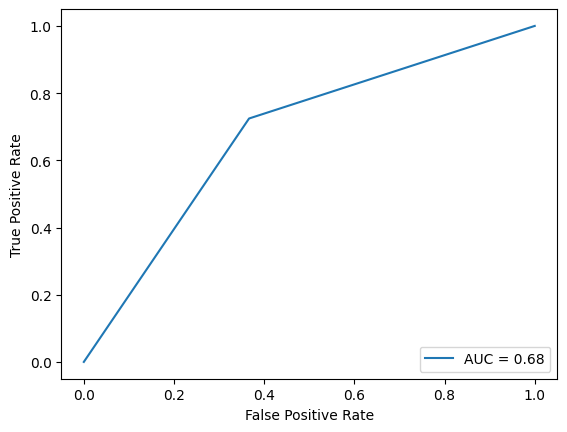

In [ ]:
l.plot()
plt.show()

In [ ]:
fewshot